#Differentiable Digital Twins in Graph Neural Networks
Students: Elad Sofer 312124662 & Tomer Shaked 31582221

#Installations, imports and Utills

In [ ]:
!pip install torch_geometric

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 8.5 MB/s eta 0:00:00


In [ ]:
import tqdm
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt

import torch
import torch.nn.functional as F


from torch_geometric.data import Data
from torch_geometric.loader import DataLoader
from torch_geometric.utils import to_dense_adj
import torch_geometric.nn as torch_geo_nn


##General Utills

These are a few of the functions needed for the rest of the code.

**calculate deleiveries**: used in the dataset generation to calculate the delivery of a graph.

**vectorised bellman ford**: a vectorised implementation of the path searching algorithm "bellman ford" used by dataset generation

**best one hop**: one step advance in the paths


**from list to adjacency and adjacency to list**: conversions from list notation and matrix notations and the reverese.

**show graph with labels**: visualize the graphs to notice the differences in weights. edge width corresponds with edge weight. the width is squared to make the comparison more clear.

In [ ]:

def calculate_deleiveries(A,X):
    best_routes = np.zeros([len(A),len(A)])
    # calculate best routes from every source to every destination
    for i in range(len(A)):
        # The Bellman Ford algorithm calculates the best routes from every starting point. It does this jointly for all
        # destination nodes using vectorized notation.
        best_routes[i] = vectorised_bellman_ford(A, i)
    return np.sum(best_routes*X)



def vectorised_bellman_ford(A,start_ind):
    current_routes = np.zeros(len(A))
    current_routes[start_ind] = 1
    pathing_improved = True
    while pathing_improved:
        new_routes = best_one_hop(A, current_routes)
        # accounting for small numerical floating point errors if the new paths are similar to the old path then we have
        # not improved the paths at all, and we can exit the algorithm
        if ((current_routes[np.arange(len(A)) != start_ind] - new_routes[np.arange(len(A)) != start_ind])**2).sum() < 10**(-8):
            pathing_improved = False
        current_routes = np.maximum(current_routes, new_routes)
        # print(current_routes)
    return current_routes


def best_one_hop(A,v):
     possiblities_mat = A.T * v
     return np.max(possiblities_mat,axis=1)

# torch to torch
def from_adjacency_tolist(A,device):
    rows, cols = torch.where(A != 0)
    edges = torch.tensor([[rows.tolist()[i], cols.tolist()[i]] for i in range(len(rows.tolist()))],device=device)
    weights = torch.tensor([A[rows, cols][i] for i in range(len(rows.tolist()))],device=device)
    return edges, weights


# torch to torch
def from_list_to_adjacency(size, edges,weights):
    A = torch.zeros([size,size])
    for idx,(i,j) in enumerate(edges):
        A[i,j] = weights[idx]
    return A
def show_graph_with_labels(adjacency_matrix):
    rows, cols = np.where(adjacency_matrix != 0)
    weighted_edges = [(rows.tolist()[i], cols.tolist()[i],round(adjacency_matrix[rows,cols].tolist()[i],2))for i in range(len(rows.tolist()))]

    gr = nx.Graph()

    gr.add_weighted_edges_from(weighted_edges)
    pos = nx.spring_layout(gr)
    nx.draw_networkx(gr, pos)
    for edge in gr.edges(data='weight'):
        nx.draw_networkx_edges(gr, pos, edgelist=[edge], width=(2*edge[2])**2)
    plt.show()

#Building the Dataset

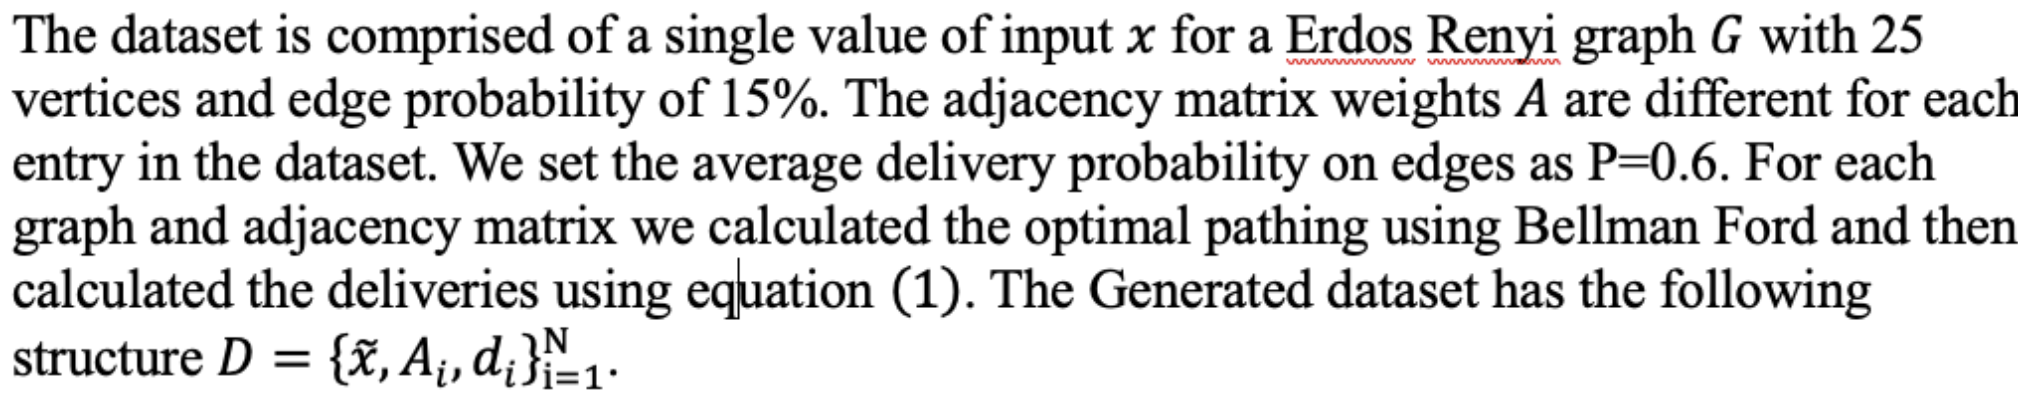

In [ ]:
class delieveries_dataset():
    def __init__(self, num_of_nodes=50, dataset_size=1000, deliver_probability=0.95, edge_percentage=0.2,epsilon=0.000001):
        self.num_of_nodes = num_of_nodes
        self.dataset_size = dataset_size
        self.deliver_probability = deliver_probability
        self.edge_percentage = edge_percentage
        self.epsilon = epsilon

    def generate_dataset(self, constant_x=True, device='cpu'):
        # generate X(packets) matrix
        X = self.random_matrix(self.num_of_nodes)
        X[np.eye(self.num_of_nodes, dtype=np.bool_)] = 0  # no self connections

        # generate A matrix's
        As = np.zeros([self.dataset_size, self.num_of_nodes, self.num_of_nodes])
        d = np.zeros(self.dataset_size)
        for i in range(self.dataset_size):
            As[i] = self.random_adjacency(self.num_of_nodes, sum=self.deliver_probability,
                                          edge_precentage=self.edge_percentage)
            # show_graph_with_labels(As[i])
            d[i] = calculate_deleiveries(As[i], X)
            if i % 2000 == 0:
                print("Creating {0} | {1} samples".format(i, d[i]))
        print("done")
        self.X = torch.tensor(X).to(device)
        self.A_list = torch.tensor(As).to(device)
        self.d_list = torch.tensor(d).to(device)
        self.dataset = [0] * self.dataset_size
        for i in range(self.dataset_size):
            edges, weights = from_adjacency_tolist(self.A_list[i],device)
            self.dataset[i] = Data(x=self.X, edge_index=edges.t().contiguous(),y=self.d_list[i])
            self.dataset[i].weights = weights
            self.dataset[i].adjacency = self.A_list[i]

    def random_adjacency(self, size, sum, edge_precentage):
        mask_matrix = self.random_matrix(size, sym=True)
        value_matrix = self.random_matrix(size, sym=True)
        # generate valid adjacency matrix
        A = np.zeros([size, size])
        A[mask_matrix < edge_precentage] = value_matrix[mask_matrix < edge_precentage]
        A[np.eye(size, dtype=np.bool_)] = 0  # no self edges
        # make sure the matrix has is connected
        A = self.make_matrix_connected(A)

        # normalize adjacency matrix
        for i in range(6):
            current_sum = A.sum()
            number_of_edges = np.count_nonzero(A)
            target_sum = sum * number_of_edges
            A = np.clip(A, 0, 1-self.epsilon)
            A = A * (target_sum / current_sum)
        return A

    def make_matrix_connected(self, M):
        mat_size = len(M)
        connected_list = []
        disconnected_list = []
        while len(connected_list) != mat_size:
            binary_map = np.where(M != 0, 1, 0) + np.eye(mat_size)
            M_v = np.linalg.matrix_power(binary_map, mat_size)  # all |V| length paths(which are all the paths)

            # test who is connected to node 0
            connected_to_0 = np.zeros(mat_size)
            connected_to_0[0] = 1
            connected_to_0 = M_v @ connected_to_0  # everyone who is connected to node 0

            connected_list = np.nonzero(connected_to_0)[0]
            disconnected_list = np.where(connected_to_0 == 0)[0]
            if len(disconnected_list) == 0:
                break
            # print(len(connected_list),self.times,self.times2)
            # plt.imshow(M_v==0)
            # plt.show()
            # choose randomly one edge to add between the connected subgraph and the disconnected subgraph
            con_idx = connected_list[np.random.randint(0, len(connected_list))]
            discon_idx = disconnected_list[np.random.randint(0, len(disconnected_list))]
            M[con_idx, discon_idx] = np.random.rand()
            M[discon_idx, con_idx] = M[con_idx, discon_idx]
        return M

    def random_matrix(self, size, sym=False):
        M = np.random.rand(size, size)
        # if we want a symmetric matrix than we simply duplicate the upper right part of the matrix to the lower left part
        if sym:
            M = np.tril(M) + np.triu(M.T, 1)
        return M



#Optimization stage

We aspire to perform optimization upon the total deliveries of the system.
As mentioned in the report we chose to do so via the Digital Twin approach.
We used 2 digital twins methods:
1. Simulation-based Digital Twin
2. GNN-based Digital Twin



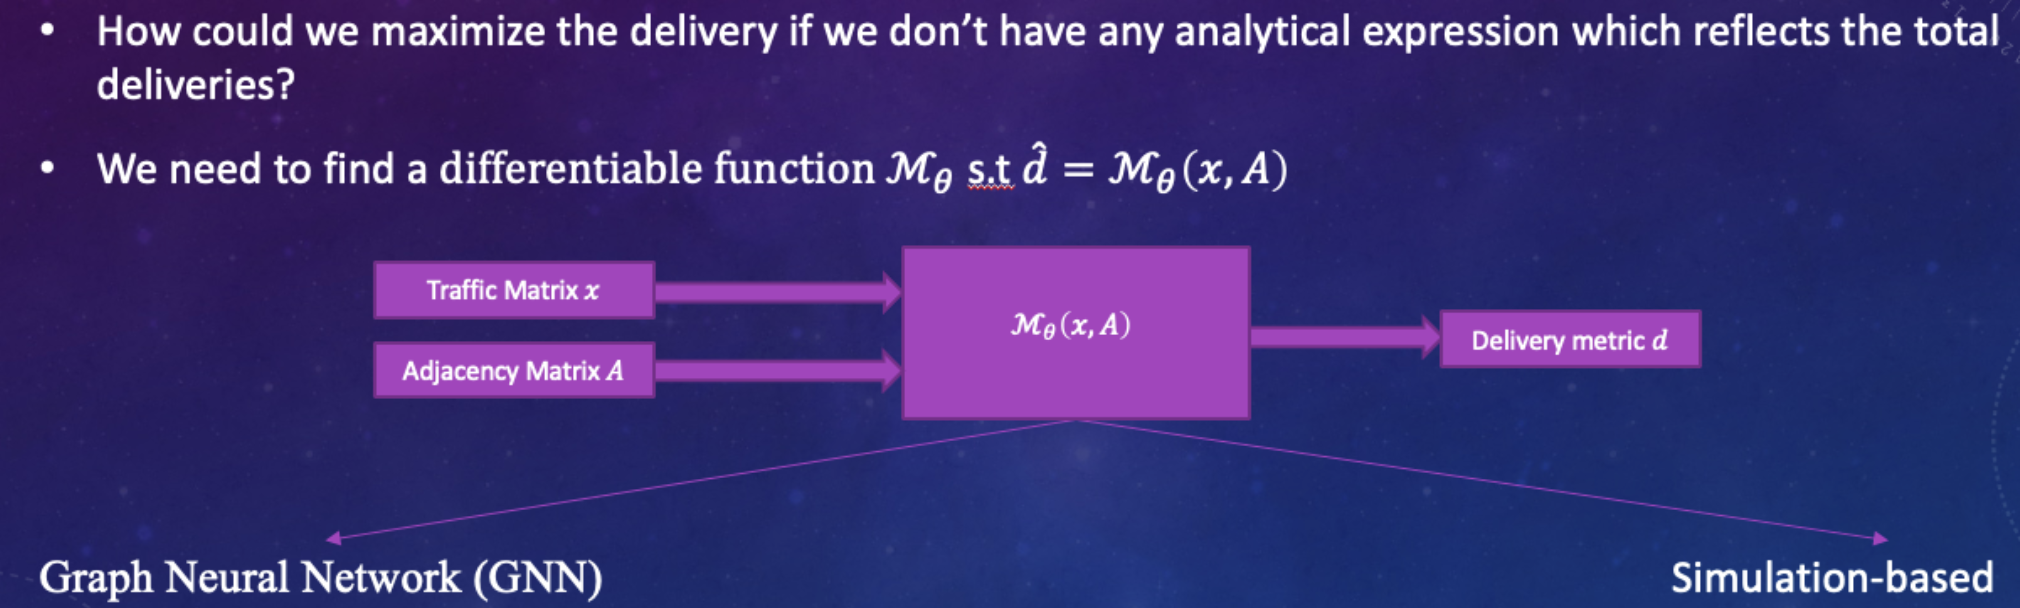

## Utills for simulation-Based using Floyd-Warshall.

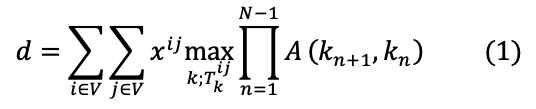

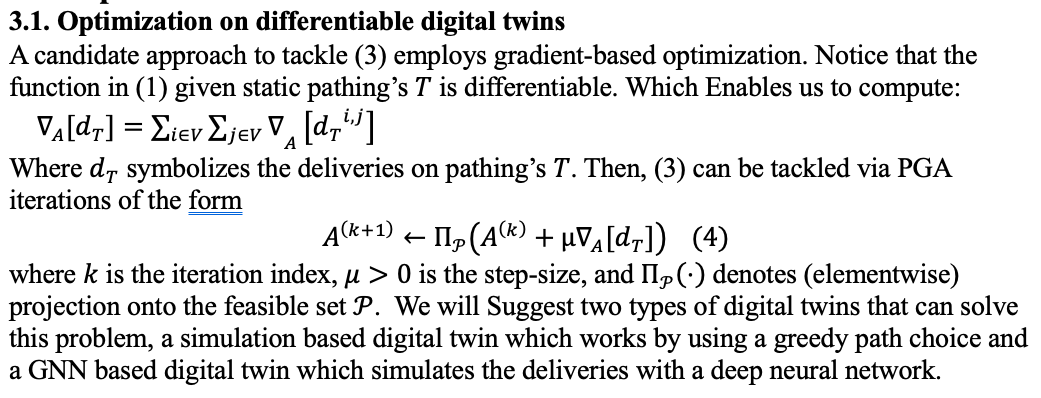

In [ ]:

def vectorized_floyd_warshall(A,device):
    mat_size = len(A)
    # initialize pathings
    output_paths = torch.fill(torch.zeros([mat_size, mat_size]),torch.nan).to(device)
    for i in range(mat_size):
        for j in range(mat_size):
            if A[i,j]!=0 or i==j:
                output_paths[i,j] = int(i)
    # initialize lengths
    output_lengths = A.detach().clone()
    output_lengths.fill_diagonal_(1)
    for k in range(mat_size):
        best_paths_for_subgraph_k = output_lengths[:,k].unsqueeze(1)*output_lengths[k,:].unsqueeze(0)
        # set pathings
        mask = (best_paths_for_subgraph_k-output_lengths)>10**(-7)
        new_paths = output_paths[k,:]
        new_paths_mat = new_paths.repeat(mat_size,1)
        output_paths[mask] = new_paths_mat[mask]
        if torch.any(output_paths<0):
            print("negative pathing!")
        # set new lengths
        output_lengths = torch.maximum(output_lengths,best_paths_for_subgraph_k)

    return output_paths.type(torch.int), output_lengths
def get_path(pathings_mat,start_ind,end_ind,device):
    if pathings_mat[start_ind,end_ind] == torch.nan:
        return []
    path = [torch.tensor(end_ind,device=device,dtype=torch.int)]
    iter = 0
    while end_ind != start_ind:
        if end_ind<0:
            print("negative?")
        end_ind = pathings_mat[start_ind,end_ind]
        # print(start_ind,end_ind)
        path.append(end_ind)
        iter = iter+1
        if iter > len(pathings_mat):
            print("error path too long...")
            exit()
            # return path
    return path

def floyd_warshall_internet(A): # from geeks to geeks
    A = A.detach().clone()
    V= len(A)
    for k in range(V):

        # pick all vertices as source one by one
        for i in range(V):

            # Pick all vertices as destination for the
            # above picked source
            for j in range(V):
                # If vertex k is on the shortest path from
                # i to j, then update the value of dist[i][j]
                A[i][j] = max(A[i][j],
                                 A[i][k] * A[k][j]
                                 )
    return A
def best_pathings(A,paths_mat,device):
    mat_size = len(A)
    pathings_tensor = torch.ones([mat_size,mat_size,mat_size],device=device)
    for start_ind in range(mat_size):
        for end_ind in range(mat_size):
            print(start_ind,end_ind)
            if start_ind == end_ind:
                continue
            path = get_path(paths_mat,start_ind,end_ind,device)
            last_node = path[-1]
            path = path[:-1]
            for step,current_node in enumerate(path[::-1]):
                pathings_tensor[start_ind,end_ind][step] = A[last_node,current_node]
    return pathings_tensor
def delivery_loss(A,paths_mat,X,device):
    mat_size = len(A)
    loss_sum = torch.zeros(1,device=device)

    for start_ind in range(mat_size):
        for end_ind in range(mat_size):
            if start_ind == end_ind:
                continue
            loss_prod = torch.ones(1,device=device)
            path = get_path(paths_mat, start_ind, end_ind, device)
            last_node = path[-1]
            path = path[:-1]
            for step, current_node in enumerate(path[::-1]):
                loss_prod = loss_prod* A[last_node, current_node]
                last_node = current_node

            loss_sum = loss_sum+ loss_prod*X[start_ind,end_ind]
    return loss_sum
def projection(A,target_sum,epsilon):
    if target_sum<torch.sum(A):
        A = target_sum*(torch.abs(A)/torch.sum(A))
    return torch.clip(A,0,1-epsilon)


## Running simulation-Based optimization

Creating 0 | 202.93141108419104 samples
done
floyd warshall initial  tensor(202.9314, dtype=torch.float64)
floyd warshall internet validation tensor(202.9314, dtype=torch.float64)
optimizing paths


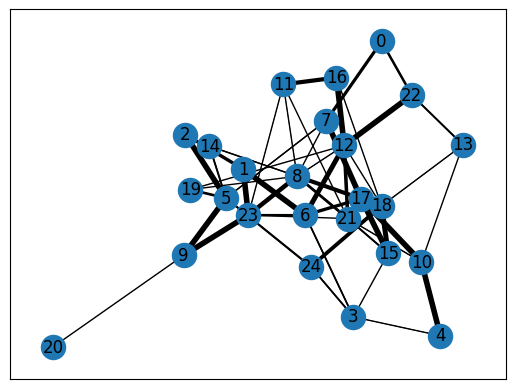

reoptimizing paths, new paths deliveries 202.93141108419104
new pathings
209.0751440541635 202.9314727783203
216.0955220968851 208.5864715576172
221.23363955009495 214.70228576660156
227.3629517415605 218.84848022460938
230.78664998341128 223.51573181152344
232.0921574769688 226.2029571533203
233.04134318140476 227.3291015625
234.07437898531867 228.23605346679688
235.13430712972695 229.23300170898438
236.0461481104378 230.25582885742188
236.8597679799716 231.15447998046875
237.6515226131956 231.9796600341797
238.4516917968221 232.80014038085938
239.26088225858825 233.63327026367188
240.07258284434013 234.47532653808594
240.88378573377037 235.32012939453125
241.67452369124467 236.1643524169922
242.522368418363 236.9890899658203
243.37580551667872 237.81509399414062
244.21389658977657 238.63961791992188
optimizing paths


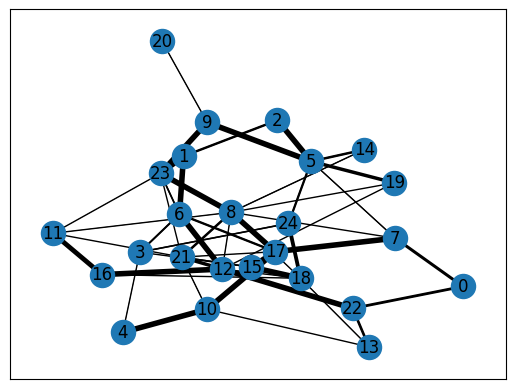

reoptimizing paths, new paths deliveries 244.21389658977657
new pathings
245.19731833807157 244.21385192871094
246.31263518990588 245.1974334716797
247.48438574372318 246.31263732910156
248.68483996138235 247.48435974121094
249.91335752696392 248.68487548828125
251.1498699957285 249.89801025390625
252.38725394490302 251.11599731445312
253.62323407953892 252.33486938476562
254.78912344866671 253.5524139404297
255.96611058266603 254.6995086669922
257.1474236326601 255.85775756835938
258.3295660926543 257.02032470703125
259.51072231100864 258.18353271484375
260.689939788025 259.34588623046875
261.8667093984713 260.5062255859375
262.9933070544471 261.66400146484375
264.1227438734006 262.7717590332031
265.25569257532266 263.88232421875
266.3891240195522 264.99615478515625
267.5214143319723 266.1105041503906
optimizing paths


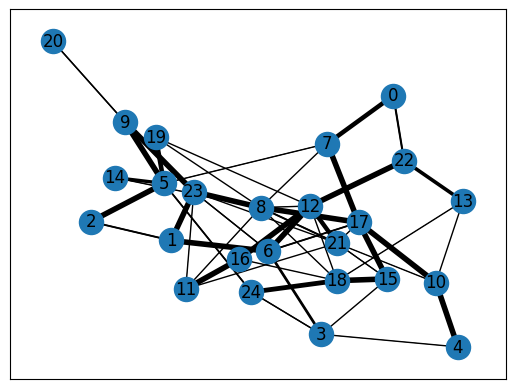

reoptimizing paths, new paths deliveries 267.5214143319723
new pathings
268.66481561746696 267.5214538574219
269.8112410717057 268.66485595703125
270.9578386994739 269.81134033203125
272.1030787304435 270.9578552246094
273.2461325854378 272.1029968261719
274.38654357963463 273.24615478515625
275.5240526608869 274.3865661621094
276.6585056174507 275.5240783691406
277.78980411642243 276.6585693359375
278.9178797283803 277.78985595703125
280.042680136901 278.91796875
281.16416180036583 280.04266357421875
282.2649561221011 281.164306640625
283.2726139569732 282.26507568359375
284.2005165538932 283.272705078125
285.11256032383335 284.2005615234375
286.0430345128558 285.11260986328125
286.9829945111835 286.0431213378906
287.86848410628005 286.98297119140625
288.6919748596504 287.8686218261719
optimizing paths


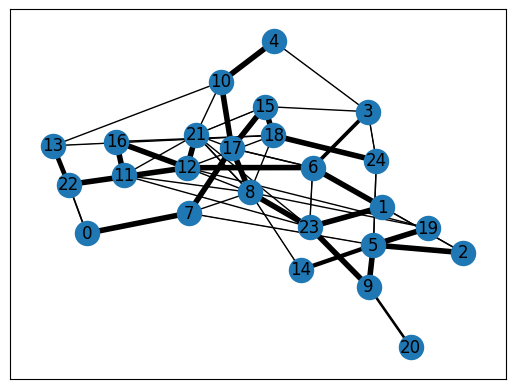

reoptimizing paths, new paths deliveries 288.6919748596504
new pathings
289.5561279451007 288.6920471191406
290.35481030886297 289.5563049316406
291.1022952574909 290.3548889160156
291.8421769100135 291.1023864746094
292.51592133360145 291.8422546386719
293.1351655684598 292.51605224609375
293.765327971376 293.1352844238281
294.4021986448409 293.7653503417969
295.04296240312635 294.4022521972656
295.6827571284682 295.0430908203125
296.2400790188442 295.6830139160156
296.7375069684358 296.2402648925781
297.1830157333967 296.73760986328125
297.61514707401597 297.1831970214844
298.05555860909186 297.61541748046875
298.4882467626628 298.0558166503906
298.8588295944779 298.4883728027344
299.23591463768406 298.85894775390625
299.5778482412144 299.236083984375
299.8816929865053 299.5780334472656
optimizing paths


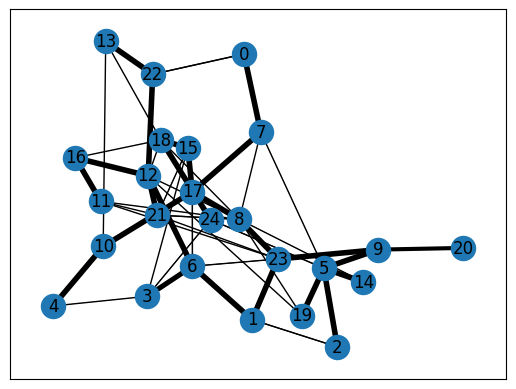

reoptimizing paths, new paths deliveries 299.8816929865053
new pathings
300.1904516908095 299.8818359375
300.5028190912011 300.1906433105469
300.8178053561785 300.5030212402344
301.1346591569645 300.8179931640625
301.45280981914516 301.1347961425781
301.6771509557972 301.45294189453125
301.90366931233245 301.67730712890625
302.1324858136161 301.90380859375
302.3629997622832 302.132568359375
302.5947443190927 302.3631286621094
302.8273564793165 302.5948486328125
303.06055388545286 302.82757568359375
303.2941168742918 303.06072998046875
303.3989596011595 303.294189453125
303.49498467442766 303.3990478515625
303.5923882298992 303.49505615234375
303.6908714619643 303.592529296875
303.7901968848389 303.6910095214844
303.89017558896245 303.7903137207031
303.9906572110701 303.8902893066406
optimizing paths


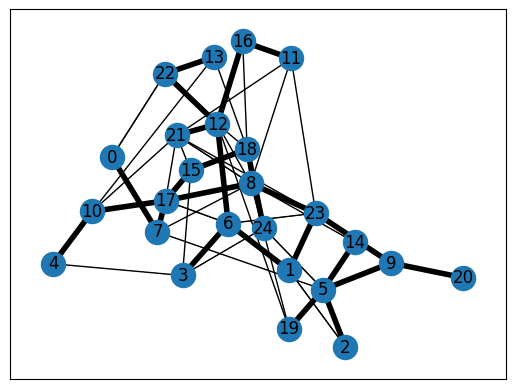

reoptimizing paths, new paths deliveries 303.9906572110701
new pathings
304.0915220137651 303.99078369140625
304.1926746177023 304.0915832519531
304.29403903049 304.1927795410156
304.3955546979634 304.2941589355469
304.4971733662858 304.39569091796875
304.5988565847874 304.4972229003906
304.70057371570255 304.5989685058594
304.80230035100806 304.7007141113281
304.904017048115 304.80242919921875
304.9133271668437 304.9040832519531
304.9133271668437 304.9134216308594
304.9133271668437 304.9134216308594
304.9133271668437 304.9134216308594
304.9133271668437 304.9134216308594
304.9133271668437 304.9134216308594
304.9133271668437 304.9134216308594
304.9133271668437 304.9134216308594
304.9133271668437 304.9134216308594
304.9133271668437 304.9134216308594
304.9133271668437 304.9134216308594
optimizing paths


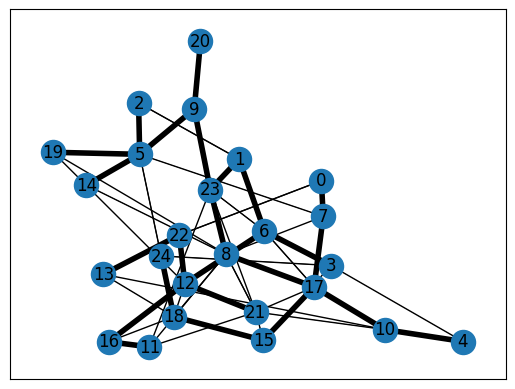

reoptimizing paths, new paths deliveries 304.9133271668437
new pathings
304.9133271668437 304.9134216308594
304.9133271668437 304.9134216308594
304.9133271668437 304.9134216308594
304.9133271668437 304.9134216308594
304.9133271668437 304.9134216308594
304.9133271668437 304.9134216308594
304.9133271668437 304.9134216308594
304.9133271668437 304.9134216308594
304.9133271668437 304.9134216308594
304.9133271668437 304.9134216308594
304.9133271668437 304.9134216308594
304.9133271668437 304.9134216308594
304.9133271668437 304.9134216308594
304.9133271668437 304.9134216308594
304.9133271668437 304.9134216308594
304.9133271668437 304.9134216308594
304.9133271668437 304.9134216308594
304.9133271668437 304.9134216308594
304.9133271668437 304.9134216308594
304.9133271668437 304.9134216308594
optimizing paths


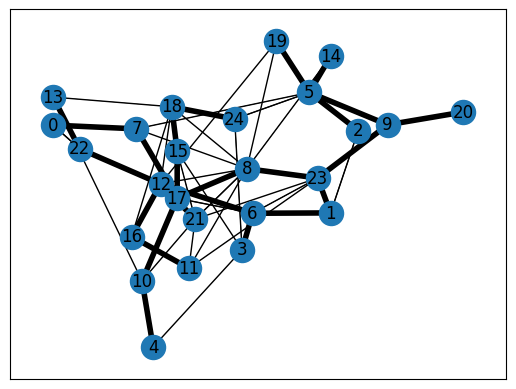

reoptimizing paths, new paths deliveries 304.9133271668437
new pathings
304.9133271668437 304.9134216308594
304.9133271668437 304.9134216308594
304.9133271668437 304.9134216308594
304.9133271668437 304.9134216308594
304.9133271668437 304.9134216308594
304.9133271668437 304.9134216308594
304.9133271668437 304.9134216308594
304.9133271668437 304.9134216308594
304.9133271668437 304.9134216308594
304.9133271668437 304.9134216308594
304.9133271668437 304.9134216308594
304.9133271668437 304.9134216308594
304.9133271668437 304.9134216308594
304.9133271668437 304.9134216308594
304.9133271668437 304.9134216308594
304.9133271668437 304.9134216308594
304.9133271668437 304.9134216308594
304.9133271668437 304.9134216308594
304.9133271668437 304.9134216308594
304.9133271668437 304.9134216308594
optimizing paths


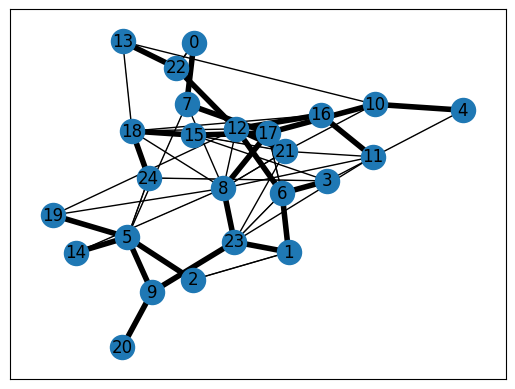

reoptimizing paths, new paths deliveries 304.9133271668437
new pathings
304.9133271668437 304.9134216308594
304.9133271668437 304.9134216308594
304.9133271668437 304.9134216308594
304.9133271668437 304.9134216308594
304.9133271668437 304.9134216308594
304.9133271668437 304.9134216308594
304.9133271668437 304.9134216308594
304.9133271668437 304.9134216308594
304.9133271668437 304.9134216308594
304.9133271668437 304.9134216308594
304.9133271668437 304.9134216308594
304.9133271668437 304.9134216308594
304.9133271668437 304.9134216308594
304.9133271668437 304.9134216308594
304.9133271668437 304.9134216308594
304.9133271668437 304.9134216308594
304.9133271668437 304.9134216308594
304.9133271668437 304.9134216308594
304.9133271668437 304.9134216308594
304.9133271668437 304.9134216308594
optimizing paths


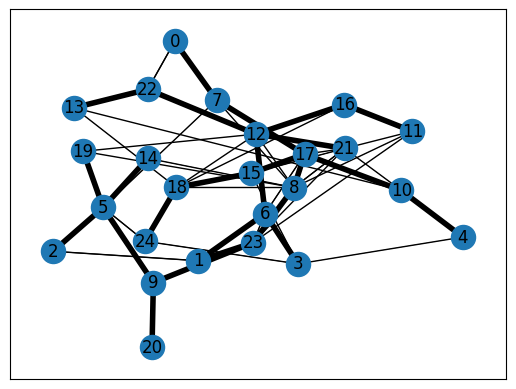

reoptimizing paths, new paths deliveries 304.9133271668437
new pathings
304.9133271668437 304.9134216308594
304.9133271668437 304.9134216308594
304.9133271668437 304.9134216308594
304.9133271668437 304.9134216308594
304.9133271668437 304.9134216308594
304.9133271668437 304.9134216308594
304.9133271668437 304.9134216308594
304.9133271668437 304.9134216308594
304.9133271668437 304.9134216308594
304.9133271668437 304.9134216308594
304.9133271668437 304.9134216308594
304.9133271668437 304.9134216308594
304.9133271668437 304.9134216308594
304.9133271668437 304.9134216308594
304.9133271668437 304.9134216308594
304.9133271668437 304.9134216308594
304.9133271668437 304.9134216308594
304.9133271668437 304.9134216308594
304.9133271668437 304.9134216308594
304.9133271668437 304.9134216308594


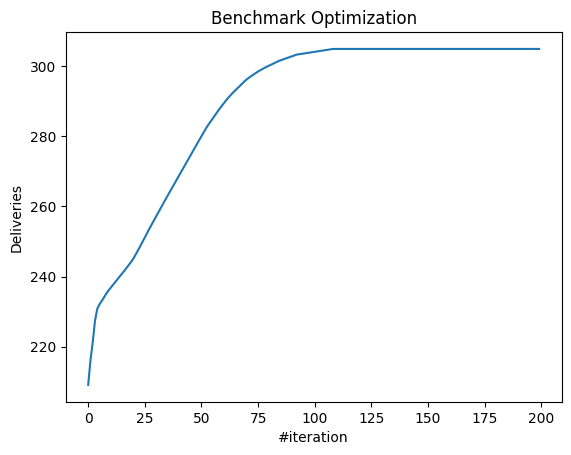

tensor(202.9314, dtype=torch.float64)
0:08:47.319186


In [ ]:
import datetime
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device = torch.device('cpu')
D = delieveries_dataset(num_of_nodes=25, dataset_size=100, edge_percentage=0.15,deliver_probability=0.6)
D.generate_dataset(device=device)
mat_shape = D.A_list[0].shape
output_paths, output_lengths = vectorized_floyd_warshall(D.A_list[0],device)
test_algorithm = floyd_warshall_internet(D.A_list[0])
print("floyd warshall initial ",(output_lengths*D.X).sum())
print("floyd warshall internet validation",(test_algorithm*D.X).sum())
A_with_grad = D.A_list[0]
iterations = 10
optimization_iters = 20
optimization_process = np.zeros(200)
start_time = datetime.datetime.now()
for i in range(iterations):
    print("optimizing paths")
    A = A_with_grad.detach().clone()
    show_graph_with_labels(A)
    output_paths, deliveries = vectorized_floyd_warshall(A,device)
    print("reoptimizing paths, new paths deliveries",(deliveries * D.X).sum().item())
    A_with_grad = A.clone().detach().requires_grad_(True).to(device)
    # pathings_tensor = best_pathings(A,output_paths,device)
    print("new pathings")
    # optimizer
    # optimizer = torch.optim.Adam([A_with_grad],lr=0.01)
    torch.autograd.set_detect_anomaly(True)

    for j in range(optimization_iters):
        A_with_grad = A_with_grad.clone().detach().requires_grad_(True).to(device)

        # loss
        loss = delivery_loss(A_with_grad,output_paths,D.X,device)
        grad = torch.autograd.grad(loss,A_with_grad)[0]
        A_with_grad = A_with_grad + 0.001*grad

        A_with_grad = projection(A_with_grad,D.deliver_probability*torch.count_nonzero(A_with_grad),D.epsilon)


        _, deliveries = vectorized_floyd_warshall(A_with_grad.detach().clone(), device)
        optimization_process[i*20+j] = (deliveries*D.X).sum().item()

        print((deliveries*D.X).sum().item(),loss.item())
end_time = datetime.datetime.now()
plt.plot(optimization_process)
plt.title("Benchmark Optimization")
plt.xlabel("#iteration")
plt.ylabel("Deliveries")
plt.show()
plt.show()
print(D.d_list[0])
print(end_time-start_time)

##Graph Neural Network Architecture

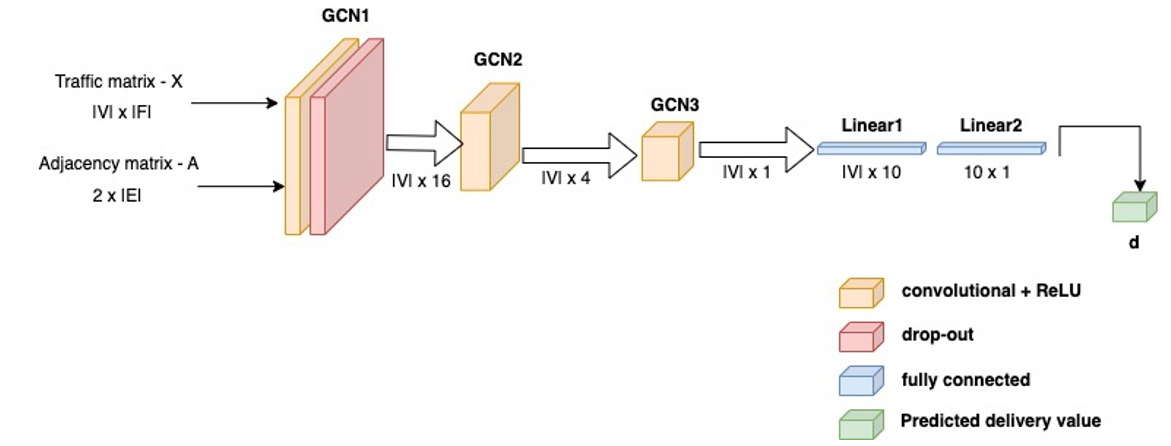

In [ ]:
class GCN(torch.nn.Module):
    def __init__(self, x_feature_num, batch_size):
        super().__init__()
        # Feature number is equal to node number |F| = |V|
        self.nodes_num = x_feature_num
        self.batch_size = batch_size
        self.conv1 = torch_geo_nn.GCNConv(x_feature_num, 16).double()
        self.conv2 = torch_geo_nn.GCNConv(16, 4).double()
        self.conv3 = torch_geo_nn.GCNConv(4, 1).double()

        self.linear1 = torch_geo_nn.Linear(self.nodes_num, 10).double()  # Changed output size to 1
        self.out = torch_geo_nn.Linear(10, 1).double()  # Changed output size to 1

    def forward(self, x, A, A_weights):
        x = self.conv1(x, A, edge_weight=A_weights)
        x = F.relu(x)
        x = F.dropout(x, training=self.training)
        x = self.conv2(x, A, edge_weight=A_weights)
        x = F.relu(x)
        x = self.conv3(x, A, edge_weight=A_weights)
        x = F.relu(x)
        x = x.reshape(-1,self.nodes_num)
        x = self.linear1(x)
        x = self.out(x)
        return x  # Removed log_softmax

##Training the GNN

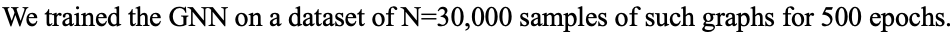

cuda
Creating 0 | 194.0081149696665 samples
Creating 2000 | 194.34867900674914 samples
Creating 4000 | 181.9805272440646 samples
Creating 6000 | 194.34862382734627 samples
Creating 8000 | 185.25586018487581 samples
done


Epoch 499, Loss 95.65222141370953:   0%|          | 0/10000 [52:15<?, ?it/s]

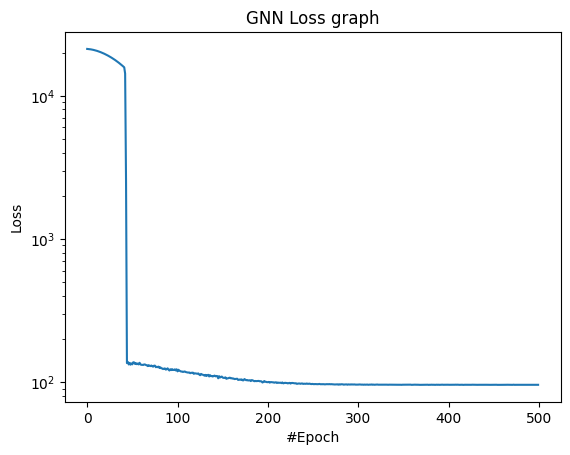

In [ ]:
num_of_nodes = 20
data_size = 10000
batch_size = 32
epochs = 500

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
# device = torch.device('cpu')
print(device)
D = delieveries_dataset(num_of_nodes=num_of_nodes, dataset_size=data_size, edge_percentage=0.2)
D.generate_dataset(device=device)
loader = DataLoader(D.dataset, batch_size=batch_size)

# in our case, feature number is equal to the node number => |F| = |V|
GNN_model = GCN(x_feature_num=num_of_nodes, batch_size=batch_size).to(device)
optimizer = torch.optim.Adam(GNN_model.parameters(), lr=0.0001, weight_decay=1e-5)

GNN_model.train()
loss_history = []
pbar = tqdm.tqdm(total=data_size)
for epoch in range(epochs):
    epoch_total_loss = 0
    for batch in loader:
        x, A, A_weights, y = batch.x, batch.edge_index, batch.weights, batch.y
        optimizer.zero_grad()
        y_hat = GNN_model(x, A, A_weights=A_weights)
        loss = F.mse_loss(y_hat, y.unsqueeze(1))
        loss.backward()
        epoch_total_loss += loss.item()
        optimizer.step()

    epoch_loss = epoch_total_loss / epochs
    pbar.set_description(f'Epoch {epoch:02d}, Loss {epoch_loss}')
    loss_history.append(epoch_loss)

plt.plot(loss_history)
plt.title("GNN Loss graph")
plt.yscale('log')
plt.xlabel("#Epoch")
plt.ylabel("Loss")
plt.show()
loader = DataLoader(D.dataset, batch_size=1)


##Running GNN optimization

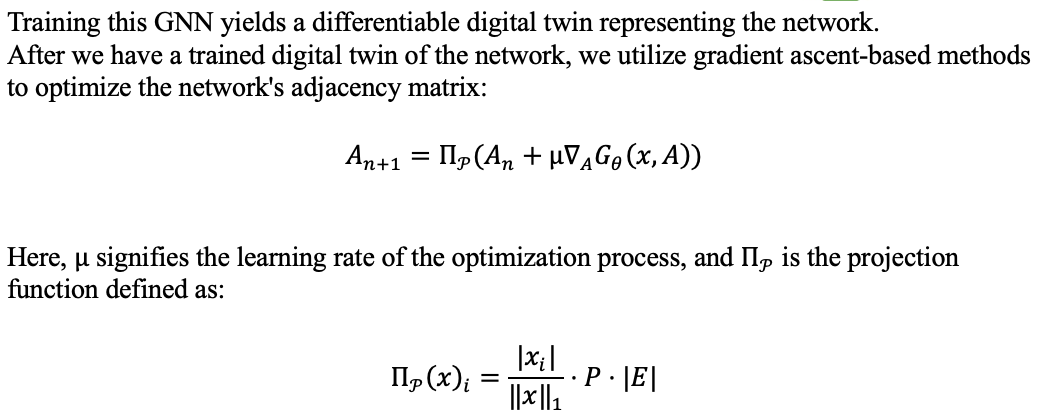

0 182.70708575805787
1 182.78445833716918
2 182.8647792310169
3 182.94969032304064
4 183.0395280898252
5 183.13637156147138
6 183.24259936781002
7 183.36430710910895
8 183.50906693285776
9 183.69131041881994
10 183.94359333393706
11 184.28060340547557
12 184.78076783288174
13 185.55113250273078
14 185.7405414273409
15 185.85092865100813
16 185.96712019153915
17 186.0999594799799
18 186.25476624034428
19 186.43949277497657
20 186.66891956845828
21 186.97424930266465
22 187.43721932378824
23 188.18368508770823
24 188.53472593773796
25 188.9315591419257
26 189.53180632216117
27 190.13596422557947
28 191.0844778694116
29 191.49182240891523
30 191.9441209895272
31 192.64578201933145
32 192.86003170635573
33 193.07306000992432
34 193.37914912299274
35 193.9190921345057
36 195.35256206718898
37 196.11751875537402
38 196.30346022683872
39 196.54462248175003
40 196.8384226521562
41 197.10008350682537
42 197.3166073849425
43 197.55447423919261
44 197.64995506362797
45 197.749329328713
46 197.837

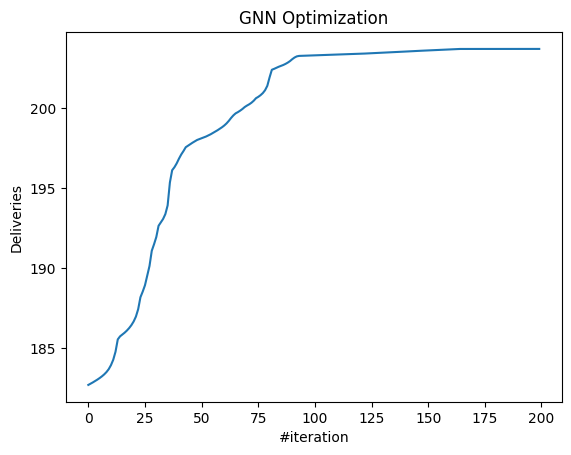

####### 203.69369505608267 #######


In [ ]:
import datetime
alpha = 0.1
GNN_model.eval()
opt_avg_cost = 0
optimization_batch_size = 1
loader = DataLoader(D.dataset, batch_size=optimization_batch_size)

sample = next(iter(loader))
x, A, A_weights, y = sample.x, sample.edge_index, sample.weights, sample.y

# A_optimizer = torch.optim.Adam(A_weights, lr=0.05)
optimization_process = np.zeros(200)
start_time = datetime.datetime.now()
for i in range(200):
  A_weights.requires_grad = True

  # print(GNN_model(x, A, A_weights))
  cost = GNN_model(x, A, A_weights)
  grad = torch.autograd.grad(cost, A_weights)[0]
  A_weights = A_weights + alpha*grad

  A_weights = projection(A_weights, D.deliver_probability * len(A.T), D.epsilon)

  A_weights = A_weights.detach()
  optimization_process[i] = cost.item()
  print(i,cost.item())
opt_avg_cost += cost.item()
end_time = datetime.datetime.now()
print(end_time-start_time)
plt.plot(optimization_process)
plt.title("GNN Optimization")
plt.xlabel("#iteration")
plt.ylabel("Deliveries")
plt.show()
plt.show()
print("####### {0} #######".format(opt_avg_cost))
